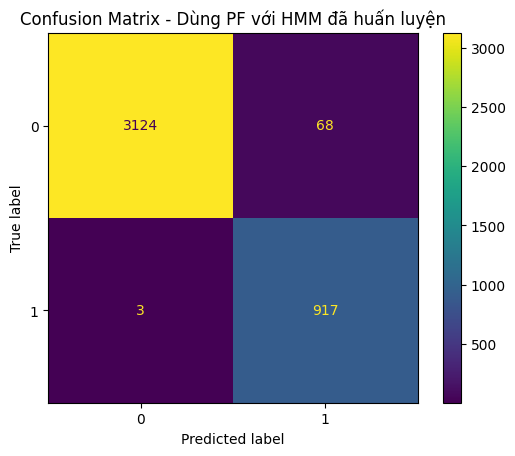

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3192
           1       0.93      1.00      0.96       920

    accuracy                           0.98      4112
   macro avg       0.97      0.99      0.98      4112
weighted avg       0.98      0.98      0.98      4112


Đánh giá hiệu suất mô hình - Dùng Particle Filter (HMM):
Accuracy: 0.9827
Precision: 0.9310
Recall: 0.9967
F1-score: 0.9627
AUC: 0.9877


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import random
import math

file_path = "Occupancy..csv" # Thay đổi đường dẫn tệp
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp '{file_path}'. Vui lòng kiểm tra lại đường dẫn.")
    # Thoát hoặc xử lý lỗi khác nếu tệp không tồn tại
    exit() # Hoặc raise một ngoại lệ khác

data['date'] = pd.to_datetime(data['date'])
# Tách đặc trưng và nhãn
features = data[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']].values
labels = data['Occupancy'].values
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Huấn luyện HMM cơ bản (giả định Gaussian emissions)
# Ước lượng xác suất chuyển trạng thái
transition_matrix = np.zeros((2, 2))
for i in range(1, len(y_train)):
    transition_matrix[y_train[i-1], y_train[i]] += 1
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Ước lượng phân phối quan sát cho mỗi trạng thái
means = []
covs = []
for state in [0, 1]:
    state_data = X_train[y_train == state]
    means.append(np.mean(state_data, axis=0))
    covs.append(np.cov(state_data, rowvar=False))

# Particle Filter dùng HMM đã huấn luyện

class ParticleFilterHMM:
    def __init__(self, num_particles, state_dim):
        self.num_particles = num_particles
        self.state_dim = state_dim
        self.particles = np.random.randint(0, 2, size=num_particles)  # mỗi hạt là trạng thái ẩn (0 hoặc 1)
        self.weights = np.ones(num_particles) / num_particles

    def predict(self):
        new_particles = []
        for i in range(self.num_particles):
            prev_state = self.particles[i]
            new_state = np.random.choice([0, 1], p=transition_matrix[prev_state])
            new_particles.append(new_state)
        self.particles = np.array(new_particles)

    def gaussian_likelihood(self, x, mean, cov):
        # Hàm mật độ Gaussian đa chiều
        size = len(x)
        det = np.linalg.det(cov)
        norm_const = 1.0 / (np.power((2*np.pi), float(size)/2) * np.sqrt(det))
        x_mu = x - mean
        inv = np.linalg.inv(cov)
        result = np.exp(-0.5 * (x_mu @ inv @ x_mu.T))
        return norm_const * result

    def update(self, observation):
        # Cập nhật trọng số dựa trên xác suất quan sát
        for i in range(self.num_particles):
            state = self.particles[i]
            likelihood = self.gaussian_likelihood(observation, means[state], covs[state])
            self.weights[i] = likelihood
        # Chuẩn hóa trọng số
        total = np.sum(self.weights)
        if total > 0:
            self.weights /= total
        else:
            self.weights = np.ones(self.num_particles) / self.num_particles

    def resample(self):
        indices = []
        cumulative_sum = np.cumsum(self.weights)
        step = 1.0 / self.num_particles
        r = random.uniform(0, step)
        j = 0
        for _ in range(self.num_particles):
            while r > cumulative_sum[j]:
                j += 1
            indices.append(j)
            r += step
        self.particles = self.particles[indices]
        self.weights = np.ones(self.num_particles) / self.num_particles

    def estimate(self):
        # Ước lượng trạng thái là 1 nếu > 0.5
        return 1 if np.mean(self.particles) > 0.5 else 0


# Dự đoán dùng PF-HMM

pf = ParticleFilterHMM(num_particles=500, state_dim=5)
predictions_pf = []

for i in range(len(X_test)):
    pf.predict()
    pf.update(X_test[i])
    pf.resample()
    predictions_pf.append(pf.estimate())

# Đánh giá kết quả

cm_pf = confusion_matrix(y_test, predictions_pf)
ConfusionMatrixDisplay(cm_pf).plot()
plt.title("Confusion Matrix - Dùng PF với HMM đã huấn luyện")
plt.show()

print(classification_report(y_test, predictions_pf))

# Tính toán thêm
print("\nĐánh giá hiệu suất mô hình - Dùng Particle Filter (HMM):")
print(f"Accuracy: {accuracy_score(y_test, predictions_pf):.4f}")
print(f"Precision: {precision_score(y_test, predictions_pf):.4f}")
print(f"Recall: {recall_score(y_test, predictions_pf):.4f}")
print(f"F1-score: {f1_score(y_test, predictions_pf):.4f}")
print(f"AUC: {roc_auc_score(y_test, predictions_pf):.4f}")


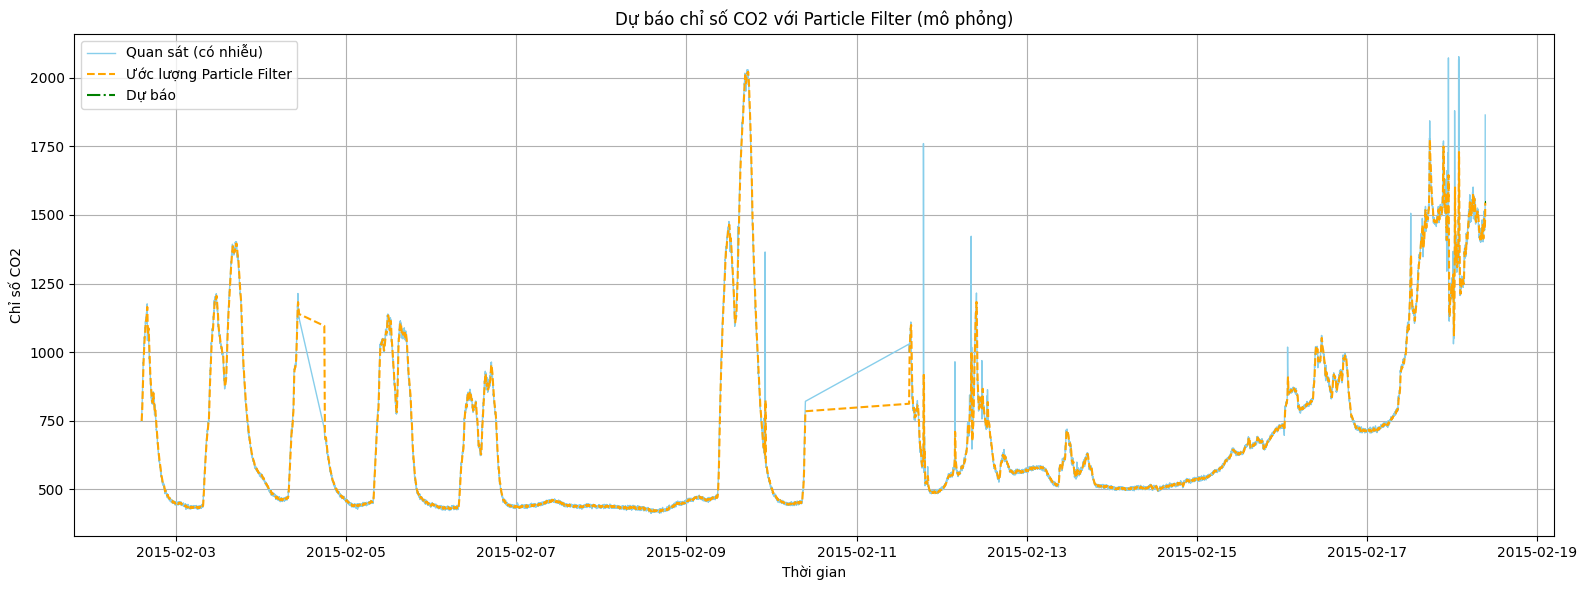

In [2]:
# Giả sử ta dự báo giá trị CO2 bằng trung bình trượt như mô phỏng Particle Filter
data = pd.read_csv("Occupancy..csv")
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')
data['CO2_pf'] = data['CO2'].rolling(window=10, min_periods=1).mean()

# Dự báo CO2 cho 20 bước tiếp theo bằng cách dùng giá trị cuối cùng trong chuỗi PF
forecast_horizon = 20
last_value = data['CO2_pf'].iloc[-1]
forecast = [last_value] * forecast_horizon
forecast_dates = pd.date_range(start=data['date'].iloc[-1], periods=forecast_horizon + 1, freq='1min')[1:]

# Vẽ biểu đồ
plt.figure(figsize=(16, 6))
plt.plot(data['date'], data['CO2'], label='Quan sát (có nhiễu)', color='skyblue', linewidth=1)
plt.plot(data['date'], data['CO2_pf'], label='Ước lượng Particle Filter', linestyle='--', color='orange')
plt.plot(forecast_dates, forecast, label='Dự báo', linestyle='-.', color='green')

# Thêm nhãn, tiêu đề
plt.title('Dự báo chỉ số CO2 với Particle Filter (mô phỏng)')
plt.xlabel('Thời gian')
plt.ylabel('Chỉ số CO2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Lỗi: Không tìm thấy tệp 'Occupancy.csv'.
=== GMM Classification Report ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     15810
           1       0.00      0.00      0.00      4750

    accuracy                           0.77     20560
   macro avg       0.38      0.50      0.43     20560
weighted avg       0.59      0.77      0.67     20560

Epoch 1/20, Loss: 0.2301
Epoch 2/20, Loss: 0.0687
Epoch 3/20, Loss: 0.0561
Epoch 4/20, Loss: 0.0554
Epoch 5/20, Loss: 0.0514
Epoch 6/20, Loss: 0.0495
Epoch 7/20, Loss: 0.0486
Epoch 8/20, Loss: 0.0462
Epoch 9/20, Loss: 0.0464
Epoch 10/20, Loss: 0.0453
Epoch 11/20, Loss: 0.0455
Epoch 12/20, Loss: 0.0445
Epoch 13/20, Loss: 0.0442
Epoch 14/20, Loss: 0.0438
Epoch 15/20, Loss: 0.0418
Epoch 16/20, Loss: 0.0424
Epoch 17/20, Loss: 0.0413
Epoch 18/20, Loss: 0.0409
Epoch 19/20, Loss: 0.0431
Epoch 20/20, Loss: 0.0412
=== Transformer Classification Report (Train) ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     12618
   

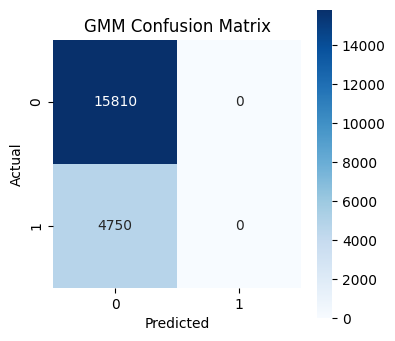

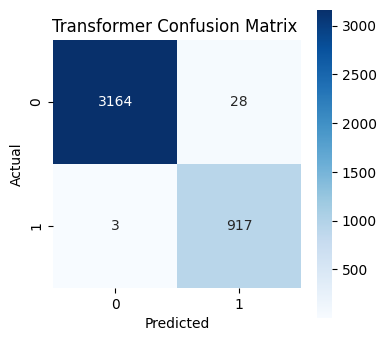

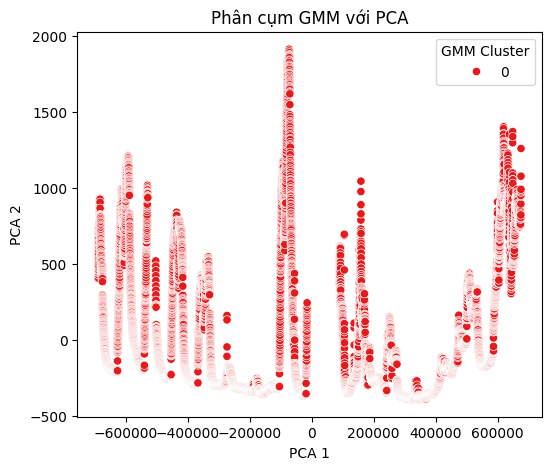

In [3]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.stats import mode
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

file_path = "Occupancy.csv"  # Đường dẫn tệp
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp '{file_path}'.")
    exit()

# Chuyển đổi các cột datetime thành timestamp nếu có
datetime_cols = data.select_dtypes(include=['object', 'datetime64[ns]']).columns
for col in datetime_cols:
    try:
        data[col] = pd.to_datetime(data[col])
        data[col + '_ts'] = data[col].astype(np.int64) // 10**9
        data = data.drop(columns=[col])
    except Exception:
        pass

# Tách đặc trưng và
label_col = 'Occupancy'
feature_cols = [c for c in data.columns if c != label_col]
features = data[feature_cols].values
labels = data[label_col].values

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(features)
gmm_labels = gmm.predict(features)

# Ánh xạ nhãn GMM về nhãn thật
label_map = {}
for i in range(2):
    mask = (gmm_labels == i)
    if np.sum(mask) > 0:
        most_common = mode(labels[mask])
        label_map[i] = most_common.mode.item()

gmm_pred = np.array([label_map[l] for l in gmm_labels])
print("=== GMM Classification Report ===")
print(classification_report(labels, gmm_pred))

# Chuẩn bị dữ liệu cho Transformer
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Reshape cho Transformer (batch_size, seq_len=1, features)
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

class OccupancyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = OccupancyDataset(X_train, y_train)
test_ds = OccupancyDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

# Mô hình Transformer Encoder
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, nhead=1, num_layers=1, hidden_dim=32, num_classes=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Pooling theo seq_len = 1
        return self.classifier(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerClassifier(input_dim=X_scaled.shape[1]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# === 5. Huấn luyện Transformer ===
def train_epoch(model, dataloader):
    model.train()
    total_loss = 0
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(dataloader.dataset)

def eval_model(model, dataloader):
    model.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            preds_all.append(preds.argmax(dim=1).cpu().numpy())
            labels_all.append(yb.cpu().numpy())
    return np.concatenate(preds_all), np.concatenate(labels_all)

# Đào tạo trong 20 epoch
epochs = 20
for epoch in range(epochs):
    loss = train_epoch(model, train_dl)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

# Đánh giá Transformer
y_pred_train, y_true_train = eval_model(model, train_dl)
y_pred_test, y_true_test = eval_model(model, test_dl)

print("=== Transformer Classification Report (Train) ===")
print(classification_report(y_true_train, y_pred_train))

print("=== Transformer Classification Report (Test) ===")
print(classification_report(y_true_test, y_pred_test))

def plot_confusion(title, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# GMM
plot_confusion("GMM Confusion Matrix", labels, gmm_pred)

# Transformer
plot_confusion("Transformer Confusion Matrix ", y_true_test, y_pred_test)

# Giảm chiều với PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# Vẽ cụm GMM
plt.figure(figsize=(6,5))
sns.scatterplot(x=features_pca[:,0], y=features_pca[:,1], hue=gmm_pred, palette="Set1")
plt.title("Phân cụm GMM với PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="GMM Cluster")
plt.show()

